# Compose: Training a model to generate music

In [1]:
import os
import pickle
import numpy
import pydot
from matplotlib import pyplot
from music21 import note, chord

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
from keras import regularizers

from models.RNNAttention import get_distinct, create_lookups, prepare_sequences, get_music_list, create_network

Using TensorFlow backend.


## Set parameters

In [2]:
# run params
section = 'compose'
run_id = 'no_dropout_reg'
genre_name = 'cello'
composer_name='Bach'

run_folder = 'run/{}/{}/'.format(section, genre_name)
run_folder += '_'.join([run_id, composer_name])


store_folder = os.path.join(run_folder, 'store')
data_folder = os.path.join('data', genre_name, composer_name)

if not os.path.exists(run_folder):
    os.mkdir(run_folder)
    os.mkdir(os.path.join(run_folder, 'store'))
    os.mkdir(os.path.join(run_folder, 'output'))
    os.mkdir(os.path.join(run_folder, 'weights'))
    os.mkdir(os.path.join(run_folder, 'viz'))
    


mode = 'load' # 'load' # 

# data params
intervals = range(1)
seq_len = 32

# model params
embed_size = 1
rnn_units = 128
use_attention = True
#reg = None
reg = regularizers.l2(0.03)
#reg = regularizers.l1_l2(l1=0.1,l2=0.1)
learning_rate = 0.001

## Extract the notes

In [3]:
data_folder

'data/cello/Bach'

In [4]:
if mode == 'build':
    
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        original_score = parser.parse(file).chordify()
        

        for interval in intervals:

            score = original_score.transpose(interval)

            notes.extend(['START'] * seq_len)
            durations.extend([0]* seq_len)
            #notes.extend(['START'])
            #durations.extend([0])

            for element in score.flat:
                
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                    else:
                        notes.append(str(element.nameWithOctave))

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)

    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pickle.dump(notes, f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f)
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f) 

## Create the lookup tables

In [5]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
#velocity_names, n_velocities = get_distinct(velocities)
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
#velocity_to_int, int_to_velocity = create_lookups(velocity_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [6]:
print('\nnote_to_int')
note_to_int


note_to_int


{'A2': 0,
 'A2.A3': 1,
 'A2.B2': 2,
 'A2.C3': 3,
 'A2.C3.D3.E3': 4,
 'A2.D3': 5,
 'A2.E-3': 6,
 'A2.E3': 7,
 'A2.E3.A3': 8,
 'A2.E3.C#4': 9,
 'A2.E3.C#4.A4': 10,
 'A2.E3.C#4.E4': 11,
 'A2.E3.C#4.G#4': 12,
 'A2.E3.C4': 13,
 'A2.E3.D4': 14,
 'A2.F#3': 15,
 'A2.F#3.C4': 16,
 'A2.F#3.D4': 17,
 'A2.F#3.D4.A4': 18,
 'A2.F#3.D4.E4': 19,
 'A2.F#3.D4.F#4': 20,
 'A2.F#4': 21,
 'A2.F3': 22,
 'A2.F3.C4': 23,
 'A2.F3.D4': 24,
 'A2.F3.D4.A4': 25,
 'A2.G3': 26,
 'A2.G3.C#4': 27,
 'A2.G3.D4': 28,
 'A3': 29,
 'A3.B-3': 30,
 'A3.B3': 31,
 'A3.B3.A4': 32,
 'A3.B3.C#4': 33,
 'A3.B3.C4': 34,
 'A3.B3.F#4.G4': 35,
 'A3.B3.G4': 36,
 'A3.C#4': 37,
 'A3.C#4.E4': 38,
 'A3.C4': 39,
 'A3.D4': 40,
 'A3.D4.E4': 41,
 'A3.D4.F#4': 42,
 'A3.E4': 43,
 'A3.E4.F#4': 44,
 'A3.E4.F#4.G4': 45,
 'A3.E4.G4': 46,
 'A3.F#4': 47,
 'A3.F#4.G4': 48,
 'A3.F4': 49,
 'A3.G#4.A4': 50,
 'A3.G4': 51,
 'A4': 52,
 'A4.B4': 53,
 'B-2': 54,
 'B-2.A3': 55,
 'B-2.B-3': 56,
 'B-2.D3': 57,
 'B-2.D3.A3': 58,
 'B-2.D3.E-3.G#3': 59,
 'B-2.D3.G#3': 

In [7]:
print('\nduration_to_int')
duration_to_int


duration_to_int


{0: 0,
 Fraction(1, 12): 1,
 Fraction(1, 6): 2,
 0.25: 3,
 Fraction(1, 3): 4,
 Fraction(5, 12): 5,
 0.5: 6,
 Fraction(2, 3): 7,
 0.75: 8,
 1.0: 9,
 1.25: 10,
 Fraction(4, 3): 11,
 1.5: 12,
 1.75: 13,
 2.0: 14,
 2.25: 15,
 2.5: 16,
 3.0: 17,
 4.0: 18}

## Prepare the sequences used by the Neural Network

In [8]:
network_input, network_output = prepare_sequences(notes, durations, lookups, distincts, seq_len)

In [9]:
print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('pitch output')
print(network_output[0][0])
print('duration output')
print(network_output[1][0])

pitch input
[460 460 460 460 460 460 460 460 460 460 460 460 460 460 460 460 460 460
 460 460 460 460 460 460 460 460 460 460 460 460 460 460]
duration input
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pitch output
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

## Create the structure of the neural network

In [10]:
model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention, reg, learning_rate)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 1)      461         input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 1)      19          input_2[0][0]                    
____________________________________________________________________________________________

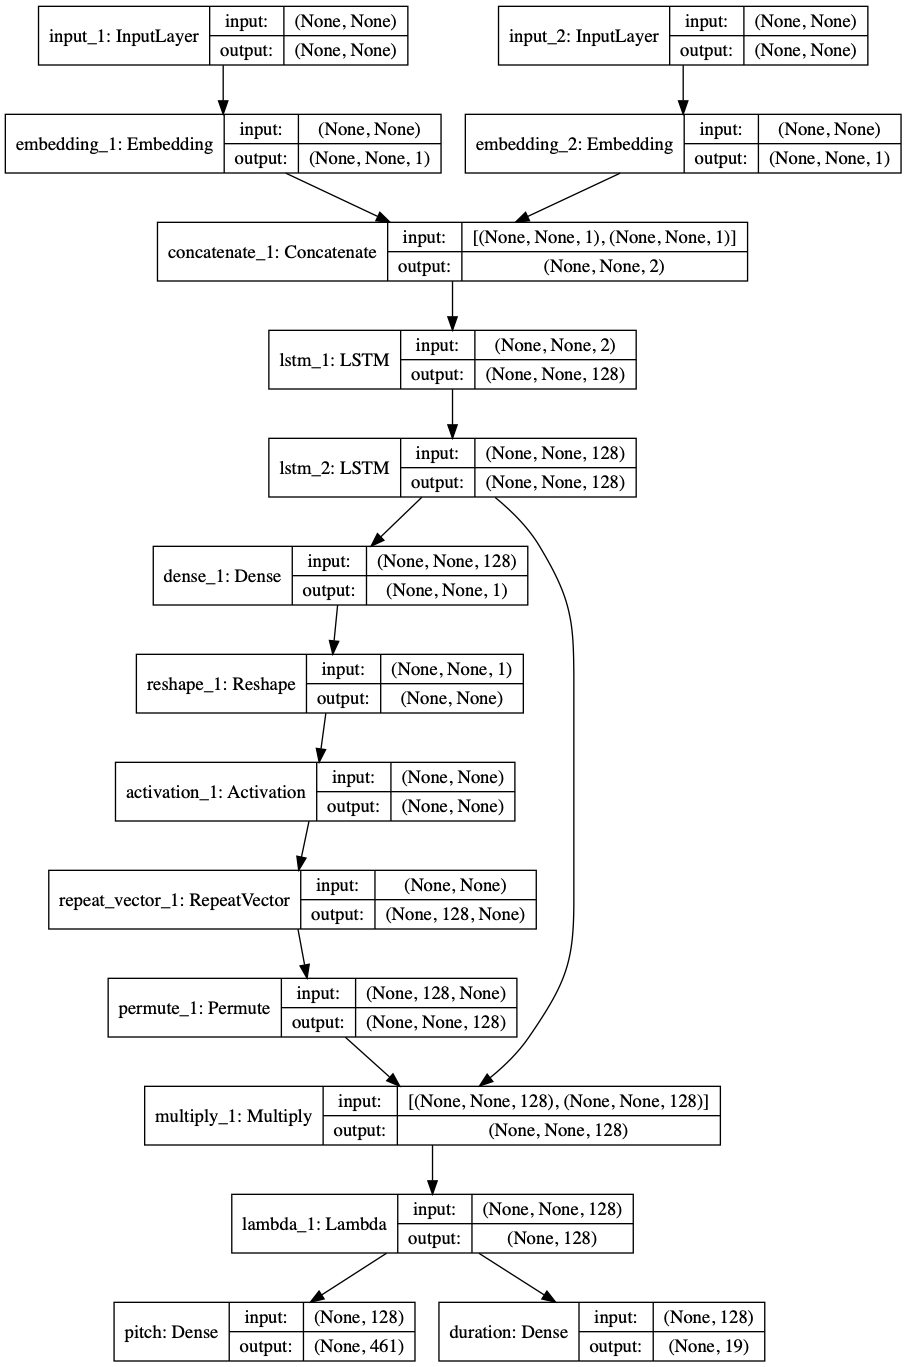

In [11]:
plot_model(model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)

## Train the neural network

In [12]:
weights_folder = os.path.join(run_folder, 'weights')
# model.load_weights(os.path.join(weights_folder, "weights.h5"))

In [ ]:
weights_folder = os.path.join(run_folder, 'weights')

checkpoint1 = ModelCheckpoint(
    os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

checkpoint2 = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 10
)


callbacks_list = [
    checkpoint1
    , checkpoint2
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))
history = model.fit(network_input, network_output
          , epochs=1000, batch_size=32
          , validation_split = 0.2
          , callbacks=callbacks_list
          , shuffle=True
         )

train_history = history.history['loss']
val_history = history.history['val_loss']



/Users/weiliang/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 23024 samples, validate on 5757 samples
Epoch 1/1000
23024/23024 [==============================] - 127s 6ms/step - loss: 5.3928 - pitch_loss: 3.8638 - duration_loss: 1.3406 - val_loss: 5.2124 - val_pitch_loss: 3.6599 - val_duration_loss: 1.5514
Epoch 2/1000
23024/23024 [==============================] - 125s 5ms/step - loss: 5.1290 - pitch_loss: 3.8042 - duration_loss: 1.3242 - val_loss: 5.1986 - val_pitch_loss: 3.6353 - val_duration_loss: 1.5609
Epoch 3/1000
23024/23024 [==============================] - 113s 5ms/step - loss: 5.1224 - pitch_loss: 3.7982 - duration_loss: 1.3236 - val_loss: 5.2046 - val_pitch_loss: 3.6320 - val_duration_loss: 1.5715
Epoch 4/1000
23024/23024 [==============================] - 113s 5ms/step - loss: 5.1179 - pitch_loss: 3.7942 - duration_loss: 1.3234 - val_loss: 5.1933 - val_pitch_loss: 3.6392 - val_duration_loss: 1.5527
Epoch 5/1000
23024/23024 [==============================] - 112s 5ms/step - loss: 5.1156 - pitch_loss: 3.7911 - duration_loss: 

23024/23024 [==============================] - 98s 4ms/step - loss: 3.9764 - pitch_loss: 3.3396 - duration_loss: 0.5748 - val_loss: 4.8525 - val_pitch_loss: 3.6302 - val_duration_loss: 1.1582
Epoch 41/1000
23024/23024 [==============================] - 106s 5ms/step - loss: 3.9757 - pitch_loss: 3.3423 - duration_loss: 0.5701 - val_loss: 4.7620 - val_pitch_loss: 3.6605 - val_duration_loss: 1.0400
Epoch 42/1000
23024/23024 [==============================] - 113s 5ms/step - loss: 3.9725 - pitch_loss: 3.3443 - duration_loss: 0.5646 - val_loss: 4.9208 - val_pitch_loss: 3.7989 - val_duration_loss: 1.0573
Epoch 43/1000
23024/23024 [==============================] - 106s 5ms/step - loss: 3.9690 - pitch_loss: 3.3481 - duration_loss: 0.5584 - val_loss: 4.9809 - val_pitch_loss: 3.6993 - val_duration_loss: 1.2186
Epoch 44/1000
23024/23024 [==============================] - 111s 5ms/step - loss: 3.9785 - pitch_loss: 3.3572 - duration_loss: 0.5580 - val_loss: 5.0185 - val_pitch_loss: 3.7857 - val_du

Epoch 80/1000
23024/23024 [==============================] - 118s 5ms/step - loss: 3.3916 - pitch_loss: 2.9044 - duration_loss: 0.3959 - val_loss: 5.8041 - val_pitch_loss: 4.2465 - val_duration_loss: 1.4644
Epoch 81/1000
23024/23024 [==============================] - 125s 5ms/step - loss: 3.3817 - pitch_loss: 2.8951 - duration_loss: 0.3940 - val_loss: 5.7648 - val_pitch_loss: 4.2723 - val_duration_loss: 1.3976
Epoch 82/1000
23024/23024 [==============================] - 120s 5ms/step - loss: 3.3632 - pitch_loss: 2.8802 - duration_loss: 0.3897 - val_loss: 5.6944 - val_pitch_loss: 4.1834 - val_duration_loss: 1.4175
Epoch 83/1000
23024/23024 [==============================] - 120s 5ms/step - loss: 3.3411 - pitch_loss: 2.8618 - duration_loss: 0.3857 - val_loss: 5.8048 - val_pitch_loss: 4.2576 - val_duration_loss: 1.4514
Epoch 84/1000
23024/23024 [==============================] - 113s 5ms/step - loss: 3.3228 - pitch_loss: 2.8425 - duration_loss: 0.3852 - val_loss: 5.7838 - val_pitch_loss: 

23024/23024 [==============================] - 124s 5ms/step - loss: 2.7968 - pitch_loss: 2.3926 - duration_loss: 0.2909 - val_loss: 6.7188 - val_pitch_loss: 4.7463 - val_duration_loss: 1.8540
Epoch 120/1000
23024/23024 [==============================] - 137s 6ms/step - loss: 2.7923 - pitch_loss: 2.3906 - duration_loss: 0.2869 - val_loss: 6.8653 - val_pitch_loss: 4.8083 - val_duration_loss: 1.9401
Epoch 121/1000
23024/23024 [==============================] - 136s 6ms/step - loss: 2.7772 - pitch_loss: 2.3796 - duration_loss: 0.2828 - val_loss: 6.7924 - val_pitch_loss: 4.8238 - val_duration_loss: 1.8543
Epoch 122/1000
23024/23024 [==============================] - 124s 5ms/step - loss: 2.7771 - pitch_loss: 2.3763 - duration_loss: 0.2865 - val_loss: 6.7992 - val_pitch_loss: 4.7766 - val_duration_loss: 1.9063
Epoch 123/1000
23024/23024 [==============================] - 151s 7ms/step - loss: 2.7671 - pitch_loss: 2.3675 - duration_loss: 0.2844 - val_loss: 6.8094 - val_pitch_loss: 4.7709 - v

23024/23024 [==============================] - 160s 7ms/step - loss: 2.4012 - pitch_loss: 2.0469 - duration_loss: 0.2273 - val_loss: 7.5388 - val_pitch_loss: 5.2195 - val_duration_loss: 2.1900
Epoch 159/1000
23024/23024 [==============================] - 142s 6ms/step - loss: 2.3837 - pitch_loss: 2.0382 - duration_loss: 0.2190 - val_loss: 7.4600 - val_pitch_loss: 5.1889 - val_duration_loss: 2.1374
Epoch 160/1000
23024/23024 [==============================] - 136s 6ms/step - loss: 2.3831 - pitch_loss: 2.0304 - duration_loss: 0.2249 - val_loss: 7.5571 - val_pitch_loss: 5.2873 - val_duration_loss: 2.1415
Epoch 161/1000
23024/23024 [==============================] - 144s 6ms/step - loss: 2.3824 - pitch_loss: 2.0319 - duration_loss: 0.2232 - val_loss: 7.3672 - val_pitch_loss: 5.2081 - val_duration_loss: 2.0298
Epoch 162/1000
23024/23024 [==============================] - 147s 6ms/step - loss: 2.3795 - pitch_loss: 2.0240 - duration_loss: 0.2275 - val_loss: 7.4775 - val_pitch_loss: 5.1610 - v

In [ ]:
pyplot.plot(train_history, color='blue', label='train')
pyplot.plot(val_history, color='orange', label='validation')
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower left')
pyplot.show()